# Advanced RNNs

In this notebook we're going to cover some advanced topics related to RNNs.

1. Conditioned hidden state
2. Char-level embeddings
3. Encoder and decoder
4. Attentional mechanisms
5. Implementation




# Set up

In [1]:
# Load PyTorch library
#!pip3 install torch

In [2]:
import os
from argparse import Namespace
import collections
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [4]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=True,
    batch_size=4,
    condition_vocab_size=3, # vocabulary for condition possibilities
    embedding_dim=100,
    rnn_hidden_dim=100,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


# Conditioned RNNs

Conditioning an RNN is to add extra information that will be helpful towards a prediction. We can encode (embed it) this information and feed it along with the sequential input into our model. For example, suppose in our document classificaiton example in the previous notebook, we knew the publisher of each news article (NYTimes, ESPN, etc.). We could have encoded that information to help with the prediction. There are several different ways of creating a conditioned RNN.

**Note**: If the conditioning information is novel for each input in the sequence, just concatenate it along with each time step's input.

1. Make the initial hidden state the encoded information instead of using the initial zerod hidden state. Make sure that the size of the encoded information is the same as the hidden state for the RNN.


<img src="figures/conditioned_rnn1.png" width=400>

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# Condition
condition = torch.LongTensor([0, 2, 1, 2]) # batch size of 4 with a vocab size of 3
condition_embeddings = nn.Embedding(
    embedding_dim=args.embedding_dim, # should be same as RNN hidden dim
    num_embeddings=args.condition_vocab_size) # of unique conditions

# Initialize hidden state
num_directions = 1
if args.bidirectional:
    num_directions = 2
    
# If using multiple layers and directions, the hidden state needs to match that size
hidden_t = condition_embeddings(condition).unsqueeze(0).repeat(
    args.num_layers * num_directions, 1, 1).to(args.device) # initial state to RNN
print (hidden_t.size())

# Feed into RNN
# y_out, _ = self.rnn(x_embedded, hidden_t)


torch.Size([1, 4, 100])


2. Concatenate the encoded information with the hidden state at each time step. Do not replace the hidden state because the RNN needs that to learn. 

<img src="figures/conditioned_rnn2.png" width=400>

In [7]:
# Initialize hidden state
hidden_t = torch.zeros((args.num_layers * num_directions, args.batch_size, args.rnn_hidden_dim))
print (hidden_t.size())

torch.Size([1, 4, 100])


In [8]:
def concat_condition(condition_embeddings, condition, hidden_t, num_layers, num_directions):
    condition_t = condition_embeddings(condition).unsqueeze(0).repeat(
        num_layers * num_directions, 1, 1)
    hidden_t = torch.cat([hidden_t, condition_t], 2)
    return hidden_t

In [9]:
# Loop through the inputs time steps
hiddens = []
seq_size = 1
for t in range(seq_size):
    hidden_t = concat_condition(condition_embeddings, condition, hidden_t, 
                                args.num_layers, num_directions).to(args.device)
    print (hidden_t.size())
    
    # Feed into RNN
    # hidden_t = rnn_cell(x_in[t], hidden_t)
    ...

torch.Size([1, 4, 200])


# Char-level embeddings

Our conv operations will have inputs that are words in a sentence represented at the character level|  $\in \mathbb{R}^{NXSXWXE}$  and outputs are embeddings for each word (based on convlutions applied at the character level.) 

**Word embeddings**: capture the temporal correlations among
adjacent tokens so that similar words have similar representations. Ex. "New Jersey" is close to "NJ" is close to "Garden State", etc.

**Char embeddings**: create representations that map words at a character level. Ex. "toy" and "toys" will be close to each other.

<img src="figures/char_embeddings.png" width=450>

In [10]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    batch_size=64,
    vocab_size=20, # vocabulary
    seq_size=10, # max length of each sentence
    word_size=15, # max length of each word
    embedding_dim=100,
    num_filters=100, # filters per size
)

In [11]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_input_channels, 
                 num_output_channels, padding_idx):
        super(Model, self).__init__()
        
        # Char-level embedding
        self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                       num_embeddings=num_embeddings,
                                       padding_idx=padding_idx)
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_output_channels, 
                                             kernel_size=f) for f in [2,3,4]])

    def forward(self, x, channel_first=False, apply_softmax=False):
        
        # x: (N, seq_len, word_len)
        input_shape = x.size()
        batch_size, seq_len, word_len = input_shape
        x = x.view(-1, word_len) # (N*seq_len, word_len)
        
        # Embedding
        x = self.embeddings(x) # (N*seq_len, word_len, embedding_dim)
        
        # Rearrange input so num_input_channels is in dim 1 (N, embedding_dim, word_len)
        if not channel_first:
            x = x.transpose(1, 2)
        
        # Convolution
        z = [F.relu(conv(x)) for conv in self.conv]
        
        # Pooling
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z] 
        z = [zz.view(batch_size, seq_len, -1) for zz in z] # (N, seq_len, embedding_dim)
        
        # Concat to get char-level embeddings
        z = torch.cat(z, 2) # join conv outputs
        
        return z

In [12]:
# Input
input_size = (args.batch_size, args.seq_size, args.word_size)
x_in = torch.randint(low=0, high=args.vocab_size, size=input_size).long()
print (x_in.size())

torch.Size([64, 10, 15])


In [13]:
# Initial char-level embedding model
model = Model(embedding_dim=args.embedding_dim, 
              num_embeddings=args.vocab_size, 
              num_input_channels=args.embedding_dim, 
              num_output_channels=args.num_filters,
              padding_idx=0)
print (model.named_modules)

<bound method Module.named_modules of Model(
  (embeddings): Embedding(20, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
)>


In [14]:
# Forward pass to get char-level embeddings
z = model(x_in)
print (z.size())

torch.Size([64, 10, 300])


There are several different ways you can use these char-level embeddings:

1. Concat char-level embeddings with word-level embeddings, since we have an embedding for each word (at a char-level) and then feed it into an RNN. 
2. You can feed the char-level embeddings into an RNN to processes them.

# Encoder and decoder

So far we've used RNNs to `encode` a sequential input and generate hidden states. We use these hidden states to `decode` the predictions. So far, the encoder was an RNN and the decoder was just a few fully connected layers followed by a softmax layer (for classification). But the encoder and decoder can assume other architectures as well. For example, the decoder could be an RNN that processes the hidden state outputs from the encoder RNN. 

In [15]:
# Arguments
args = Namespace(
    batch_size=64,
    embedding_dim=100,
    rnn_hidden_dim=100,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
    dropout=0.1,
)

In [16]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, rnn_hidden_dim, 
                 num_layers, bidirectional, padding_idx=0):
        super(Encoder, self).__init__()
        
        # Embeddings
        self.word_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                            num_embeddings=num_embeddings,
                                            padding_idx=padding_idx)
        
        # GRU weights
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=rnn_hidden_dim, 
                          num_layers=num_layers, batch_first=True, 
                          bidirectional=bidirectional)

    def forward(self, x_in, x_lengths):
        
        # Word level embeddings
        z_word = self.word_embeddings(x_in)
   
        # Feed into RNN
        out, h_n = self.gru(z)
        
        # Gather the last relevant hidden state
        out = gather_last_relevant_hidden(out, x_lengths)
        
        return out

In [17]:
class Decoder(nn.Module):
    def __init__(self, rnn_hidden_dim, hidden_dim, output_dim, dropout_p):
        super(Decoder, self).__init__()
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, encoder_output, apply_softmax=False):
        
        # FC layers
        z = self.dropout(encoder_output)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [18]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, rnn_hidden_dim, 
                 hidden_dim, num_layers, bidirectional, output_dim, dropout_p, 
                 padding_idx=0):
        super(Model, self).__init__()
        self.encoder = Encoder(embedding_dim, num_embeddings, rnn_hidden_dim, 
                               num_layers, bidirectional, padding_idx=0)
        self.decoder = Decoder(rnn_hidden_dim, hidden_dim, output_dim, dropout_p)
        
    def forward(self, x_in, x_lengths, apply_softmax=False):
        encoder_outputs = self.encoder(x_in, x_lengths)
        y_pred = self.decoder(encoder_outputs, apply_softmax)
        return y_pred

In [19]:
model = Model(embedding_dim=args.embedding_dim, num_embeddings=1000, 
              rnn_hidden_dim=args.rnn_hidden_dim, hidden_dim=args.hidden_dim, 
              num_layers=args.num_layers, bidirectional=args.bidirectional, 
              output_dim=4, dropout_p=args.dropout, padding_idx=0)
print (model.named_parameters)

<bound method Module.named_parameters of Model(
  (encoder): Encoder(
    (word_embeddings): Embedding(1000, 100, padding_idx=0)
    (gru): GRU(100, 100, batch_first=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.1)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=4, bias=True)
  )
)>


# Attentional mechanisms

When processing an input sequence with an RNN, recall that at each time step we process the input and the hidden state at that time step. For many use cases, it's advantageous to have access to the inputs at all time steps and pay selective attention to the them at each time step. For example, in machine translation, it's advantageous to have access to all the words when translating to another language because translations aren't necessarily word for word. 

<img src="figures/attention1.jpg" width=650>

Attention can sound a bit confusing so let's see what happens at each time step. At time step j, the model has processed inputs $x_0, x_1, x_2, ..., x_j$ and has generted hidden states $h_0, h_1, h_2, ..., h_j$. The idea is to use all the processed hidden states to make the prediction and not just the most recent one. There are several approaches to how we can do this.

With **soft attention**, we learn a vector of floating points (probabilities) to multiply with the hidden states to create the context vector.

Ex. [0.1, 0.3, 0.1, 0.4, 0.1]

With **hard attention**, we can learn a binary vector to multiply with the hidden states to create the context vector. 

Ex. [0, 0, 0, 1, 0]

We're going to focus on soft attention because it's more widley used and we can visualize how much of each hidden state helps with the prediction, which is great for interpretability. 

<img src="figures/attention2.jpg" width=650>

We're going to implement attention in the document classification task below.

# Document classification with RNNs

We're going to implement the same document classification task as in the previous notebook but we're going to use an attentional interface for interpretability.

**Why not machine translation?** Normally, machine translation is the go-to example for demonstrating attention but it's not really practical. How many situations can you think of that require a seq to generate another sequence? Instead we're going to apply attention with our document classification example to see which input tokens are more influential towards predicting the genre.

## Set up

In [20]:
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import urllib
import torch
import copy
import json
import re

In [21]:
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [22]:
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_file="data/news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    pretrained_embeddings=None,
    cutoff=25,
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=128,
    embedding_dim=100,
    kernels=[3,5],
    num_filters=100,
    rnn_hidden_dim=128,
    hidden_dim=200,
    num_layers=1,
    bidirectional=False,
    dropout_p=0.25,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


## Data

In [23]:
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [24]:
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [25]:
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [26]:
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    84000
test     18000
val      18000
Name: split, dtype: int64

In [27]:
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text
    
split_df.title = split_df.title.apply(preprocess_text)
split_df.head()

,category,split,title
0,Business,train,general electric posts higher rd quarter profit
1,Business,train,lilly to eliminate up to us jobs
2,Business,train,s amp p lowers america west outlook to negative
3,Business,train,does rand walk the talk on labor policy ?
4,Business,train,housekeeper advocates for changes


## Vocabulary

In [28]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [29]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("Business")
print (index)
print (category_vocab.lookup_index(index))

<Vocabulary(size=4)>
4
0
Business


## Sequence vocabulary

Next, we're going to create our Vocabulary classes for the article's title, which is a sequence of words.

In [30]:
from collections import Counter
import string

In [31]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [32]:
# Get word counts
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# Create SequenceVocabulary instance
title_word_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_word_vocab.add_token(word)
print (title_word_vocab) # __str__
print (len(title_word_vocab)) # __len__
index = title_word_vocab.lookup_token("general")
print (index)
print (title_word_vocab.lookup_index(index))

<SequenceVocabulary(size=4400)>
4400
4
general


We're also going to create an instance fo SequenceVocabulary that processes the input on a character level.

In [33]:
# Create SequenceVocabulary instance
title_char_vocab = SequenceVocabulary()
for title in split_df.title:
    for token in title:
        title_char_vocab.add_token(token)
print (title_char_vocab) # __str__
print (len(title_char_vocab)) # __len__
index = title_char_vocab.lookup_token("g")
print (index)
print (title_char_vocab.lookup_index(index))

<SequenceVocabulary(size=35)>
35
4
g


## Vectorizer

Something new that we introduce in this Vectorizer is calculating the length of our input sequence. We will use this later on to extract the last relevant hidden state for each input sequence.

In [34]:
class NewsVectorizer(object):
    def __init__(self, title_word_vocab, title_char_vocab, category_vocab):
        self.title_word_vocab = title_word_vocab
        self.title_char_vocab = title_char_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title):
       
        # Word-level vectorization
        word_indices = [self.title_word_vocab.lookup_token(token) for token in title.split(" ")]
        word_indices = [self.title_word_vocab.begin_seq_index] + word_indices + \
            [self.title_word_vocab.end_seq_index]
        title_length = len(word_indices)
        word_vector = np.zeros(title_length, dtype=np.int64)
        word_vector[:len(word_indices)] = word_indices
        
        # Char-level vectorization
        word_length = max([len(word) for word in title.split(" ")])
        char_vector = np.zeros((len(word_vector), word_length), dtype=np.int64)
        char_vector[0, :] = self.title_word_vocab.mask_index # <BEGIN>
        char_vector[-1, :] = self.title_word_vocab.mask_index # <END>
        for i, word in enumerate(title.split(" ")):
            char_vector[i+1,:len(word)] = [title_char_vocab.lookup_token(char) \
                                           for char in word] # i+1 b/c of <BEGIN> token
                
        return word_vector, char_vector, len(word_indices)
    
    def unvectorize_word_vector(self, word_vector):
        tokens = [self.title_word_vocab.lookup_index(index) for index in word_vector]
        title = " ".join(token for token in tokens)
        return title
    
    def unvectorize_char_vector(self, char_vector):
        title = ""
        for word_vector in char_vector:
            for index in word_vector:
                if index == self.title_char_vocab.mask_index:
                    break
                title += self.title_char_vocab.lookup_index(index)
            title += " "
        return title
    
    @classmethod
    def from_dataframe(cls, df, cutoff):
        
        # Create class vocab
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # Get word counts
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # Create title vocab (word level)
        title_word_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_word_vocab.add_token(word)
                
        # Create title vocab (char level)
        title_char_vocab = SequenceVocabulary()
        for title in df.title:
            for token in title:
                title_char_vocab.add_token(token)
        
        return cls(title_word_vocab, title_char_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_word_vocab = SequenceVocabulary.from_serializable(contents['title_word_vocab'])
        title_char_vocab = SequenceVocabulary.from_serializable(contents['title_char_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_word_vocab=title_word_vocab, 
                   title_char_vocab=title_char_vocab, 
                   category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_word_vocab': self.title_word_vocab.to_serializable(),
                'title_char_vocab': self.title_char_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [35]:
# Vectorizer instance
vectorizer = NewsVectorizer.from_dataframe(split_df, cutoff=args.cutoff)
print (vectorizer.title_word_vocab)
print (vectorizer.title_char_vocab)
print (vectorizer.category_vocab)
word_vector, char_vector, title_length = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print ("word_vector:", np.shape(word_vector))
print ("char_vector:", np.shape(char_vector))
print ("title_length:", title_length)
print (word_vector)
print (char_vector)
print (vectorizer.unvectorize_word_vector(word_vector))
print (vectorizer.unvectorize_char_vector(char_vector))

<SequenceVocabulary(size=4404)>
<SequenceVocabulary(size=35)>
<Vocabulary(size=4)>
word_vector: (10,)
char_vector: (10, 10)
title_length: 10
[   2    1 4151 1231   25    1 2392 4076   38    3]
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 7 15  4  5  7  0  0  0  0  0]
 [21  5 18  5  7  5  7  0  0  0]
 [26 13  6 16  0  0  0  0  0  0]
 [12 17  5  0  0  0  0  0  0  0]
 [26 13 23 25  9  5 18 15  6  0]
 [12  5  6  6 13 16  0  0  0  0]
 [12 15 20  7  6  8 23  5  6 12]
 [30  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament . <END>
 roger federer wins the wimbledon tennis tournament .  


## Dataset

In [36]:
from torch.utils.data import Dataset, DataLoader

In [37]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df, cutoff):
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_word_vector, title_char_vector, title_length = \
            self.vectorizer.vectorize(row.title)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title_word_vector': title_word_vector, 
                'title_char_vector': title_char_vector, 
                'title_length': title_length, 
                'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [38]:
# Dataset instance
dataset = NewsDataset.load_dataset_and_make_vectorizer(df=split_df,
                                                       cutoff=args.cutoff)
print (dataset) # __str__
input_ = dataset[10] # __getitem__
print (input_['title_word_vector'])
print (input_['title_char_vector'])
print (input_['title_length'])
print (input_['category'])
print (dataset.vectorizer.unvectorize_word_vector(input_['title_word_vector']))
print (dataset.vectorizer.unvectorize_char_vector(input_['title_char_vector']))
print (dataset.class_weights)

<Dataset(split=train, size=84000)
[ 2 51  1 52 53 26 54  3]
[[ 0  0  0  0  0  0  0  0  0  0]
 [18  5  9 12  8  0  0  0  0  0]
 [18 15 18  4  5 16  0  0  0  0]
 [25  8  6 27  7 20 14 12 11 22]
 [26 13 12 17  0  0  0  0  0  0]
 [ 9  8 25 15  7  0  0  0  0  0]
 [18  5  8  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
8
0
<BEGIN> delta <UNK> bankruptcy with labor deal <END>
 delta dodges bankruptcy with labor deal  
tensor([3.3333e-05, 3.3333e-05, 3.3333e-05, 3.3333e-05])


## Model

embed → encoder → attend → predict

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class NewsEncoder(nn.Module):
    def __init__(self, embedding_dim, num_word_embeddings, num_char_embeddings,
                 kernels, num_input_channels, num_output_channels, 
                 rnn_hidden_dim, num_layers, bidirectional, 
                 word_padding_idx=0, char_padding_idx=0):
        super(NewsEncoder, self).__init__()
        
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # Embeddings
        self.word_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                            num_embeddings=num_word_embeddings,
                                            padding_idx=word_padding_idx)
        self.char_embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                            num_embeddings=num_char_embeddings,
                                            padding_idx=char_padding_idx)
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, 
                                             num_output_channels, 
                                             kernel_size=f) for f in kernels])
        
        
        # GRU weights
        self.gru = nn.GRU(input_size=embedding_dim*(len(kernels)+1), 
                          hidden_size=rnn_hidden_dim, num_layers=num_layers, 
                          batch_first=True, bidirectional=bidirectional)
        
    def initialize_hidden_state(self, batch_size, rnn_hidden_dim, device):
        """Modify this to condition the RNN."""
        num_directions = 1
        if self.bidirectional:
            num_directions = 2
        hidden_t = torch.zeros(self.num_layers * num_directions, 
                               batch_size, rnn_hidden_dim).to(device)
        
    def get_char_level_embeddings(self, x):
        # x: (N, seq_len, word_len)
        input_shape = x.size()
        batch_size, seq_len, word_len = input_shape
        x = x.view(-1, word_len) # (N*seq_len, word_len)
        
        # Embedding
        x = self.char_embeddings(x) # (N*seq_len, word_len, embedding_dim)
        
        # Rearrange input so num_input_channels is in dim 1 (N, embedding_dim, word_len)
        x = x.transpose(1, 2)
        
        # Convolution
        z = [F.relu(conv(x)) for conv in self.conv]
        
        # Pooling
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z] 
        z = [zz.view(batch_size, seq_len, -1) for zz in z] # (N, seq_len, embedding_dim)
        
        # Concat to get char-level embeddings
        z = torch.cat(z, 2) # join conv outputs
        
        return z
        
    def forward(self, x_word, x_char, x_lengths, device):
        """
        x_word: word level representation (N, seq_size)
        x_char: char level representation (N, seq_size, word_len)
        """
        
        # Word level embeddings
        z_word = self.word_embeddings(x_word)
        
        # Char level embeddings
        z_char = self.get_char_level_embeddings(x=x_char)
        
        # Concatenate
        z = torch.cat([z_word, z_char], 2)
        
        # Feed into RNN
        initial_h = self.initialize_hidden_state(
            batch_size=z.size(0), rnn_hidden_dim=self.gru.hidden_size,
            device=device)
        out, h_n = self.gru(z, initial_h)
        
        return out

In [41]:
class NewsDecoder(nn.Module):
    def __init__(self, rnn_hidden_dim, hidden_dim, output_dim, dropout_p):
        super(NewsDecoder, self).__init__()
        
        # Attention FC layer
        self.fc_attn = nn.Linear(rnn_hidden_dim, rnn_hidden_dim)
        self.v = nn.Parameter(torch.rand(rnn_hidden_dim))
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, encoder_outputs, apply_softmax=False):
        
        # Attention
        z = torch.tanh(self.fc_attn(encoder_outputs))
        z = z.transpose(2,1) # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0),1).unsqueeze(1) #[B*1*H]
        z = torch.bmm(v,z).squeeze(1) # [B*T]
        attn_scores = F.softmax(z, dim=1)
        context = torch.matmul(encoder_outputs.transpose(-2, -1), 
                               attn_scores.unsqueeze(dim=2)).squeeze()
        if len(context.size()) == 1:
            context = context.unsqueeze(0)
        
        # FC layers
        z = self.dropout(context)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return attn_scores, y_pred

In [42]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_word_embeddings, num_char_embeddings,
                 kernels, num_input_channels, num_output_channels, 
                 rnn_hidden_dim, hidden_dim, output_dim, num_layers, 
                 bidirectional, dropout_p, word_padding_idx, char_padding_idx):
        super(NewsModel, self).__init__()
        self.encoder = NewsEncoder(embedding_dim, num_word_embeddings,
                                   num_char_embeddings, kernels, 
                                   num_input_channels, num_output_channels, 
                                   rnn_hidden_dim, num_layers, bidirectional, 
                                   word_padding_idx, char_padding_idx)
        self.decoder = NewsDecoder(rnn_hidden_dim, hidden_dim, output_dim, 
                                   dropout_p)
        
    def forward(self, x_word, x_char, x_lengths, device, apply_softmax=False):
        encoder_outputs = self.encoder(x_word, x_char, x_lengths, device)
        y_pred = self.decoder(encoder_outputs, apply_softmax)
        return y_pred

## Training

In [43]:
import torch.optim as optim

In [44]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, 
                 shuffle, num_epochs, batch_size, learning_rate, 
                 early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.device = device
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_word_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        vector[:len(seq)] = seq
        vector[len(seq):] = self.dataset.vectorizer.title_word_vocab.mask_index
        return vector
    
    def pad_char_seq(self, seq, seq_length, word_length):
        vector = np.zeros((seq_length, word_length), dtype=np.int64)
        vector.fill(self.dataset.vectorizer.title_char_vocab.mask_index)
        for i in range(len(seq)):
            char_padding = np.zeros(word_length-len(seq[i]), dtype=np.int64)
            vector[i] = np.concatenate((seq[i], char_padding), axis=None)
        return vector
        
    def collate_fn(self, batch):
        
        # Make a deep copy
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"title_word_vector": [], "title_char_vector": [], 
                           "title_length": [], "category": []}
             
        # Max lengths
        get_seq_length = lambda sample: len(sample["title_word_vector"])
        get_word_length = lambda sample: len(sample["title_char_vector"][0])
        max_seq_length = max(map(get_seq_length, batch))
        max_word_length = max(map(get_word_length, batch))


        # Pad
        for i, sample in enumerate(batch_copy):
            padded_word_seq = self.pad_word_seq(
                sample["title_word_vector"], max_seq_length)
            padded_char_seq = self.pad_char_seq(
                sample["title_char_vector"], max_seq_length, max_word_length)
            processed_batch["title_word_vector"].append(padded_word_seq)
            processed_batch["title_char_vector"].append(padded_char_seq)
            processed_batch["title_length"].append(sample["title_length"])
            processed_batch["category"].append(sample["category"])
            
        # Convert to appropriate tensor types
        processed_batch["title_word_vector"] = torch.LongTensor(
            processed_batch["title_word_vector"])
        processed_batch["title_char_vector"] = torch.LongTensor(
            processed_batch["title_char_vector"])
        processed_batch["title_length"] = torch.LongTensor(
            processed_batch["title_length"])
        processed_batch["category"] = torch.LongTensor(
            processed_batch["category"])
        
        return processed_batch  
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()
                
                # compute the output
                _, y_pred = self.model(x_word=batch_dict['title_word_vector'],
                                       x_char=batch_dict['title_char_vector'],
                                       x_lengths=batch_dict['title_length'],
                                       device=self.device)
                
                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0, set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                _, y_pred = self.model(x_word=batch_dict['title_word_vector'],
                                       x_char=batch_dict['title_char_vector'],
                                       x_lengths=batch_dict['title_length'],
                                       device=self.device)

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0, set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, collate_fn=self.collate_fn, 
            shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            _, y_pred = self.model(x_word=batch_dict['title_word_vector'],
                                   x_char=batch_dict['title_char_vector'],
                                   x_lengths=batch_dict['title_length'],
                                   device=self.device)

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        self.train_state["done_training"] = True
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [45]:
# Initialization
dataset = NewsDataset.load_dataset_and_make_vectorizer(df=split_df,
                                                       cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_word_embeddings=len(vectorizer.title_word_vocab), 
                  num_char_embeddings=len(vectorizer.title_char_vocab),
                  kernels=args.kernels,
                  num_input_channels=args.embedding_dim,
                  num_output_channels=args.num_filters,
                  rnn_hidden_dim=args.rnn_hidden_dim,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  word_padding_idx=vectorizer.title_word_vocab.mask_index,
                  char_padding_idx=vectorizer.title_char_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (encoder): NewsEncoder(
    (word_embeddings): Embedding(3406, 100, padding_idx=0)
    (char_embeddings): Embedding(35, 100, padding_idx=0)
    (conv): ModuleList(
      (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
    )
    (gru): GRU(300, 128, batch_first=True)
  )
  (decoder): NewsDecoder(
    (fc_attn): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.25)
    (fc1): Linear(in_features=128, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=4, bias=True)
  )
)>


In [46]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.77 | [TRAIN ACC]: 68.8% | [VAL LOSS]: 0.55 | [VAL ACC]: 79.8%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.49 | [TRAIN ACC]: 82.3% | [VAL LOSS]: 0.49 | [VAL ACC]: 82.1%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.43 | [TRAIN ACC]: 84.7% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.5%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.38 | [TRAIN ACC]: 86.4% | [VAL LOSS]: 0.45 | [VAL ACC]: 84.2%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.35 | [TRAIN ACC]: 87.7% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.4%


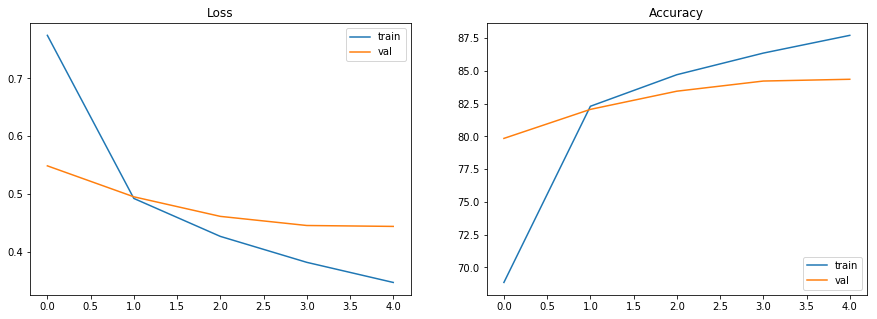

In [47]:
# Plot performance
trainer.plot_performance()

In [48]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.44
Test Accuracy: 84.7%


In [49]:
# Save all results
trainer.save_train_state()

## Inference

In [50]:
class Inference(object):
    def __init__(self, model, vectorizer, device="cpu"):
        self.model = model.to(device)
        self.vectorizer = vectorizer
        self.device = device
  
    def predict_category(self, dataset):
        # Batch generator
        batch_generator = dataset.generate_batches(
            batch_size=len(dataset), shuffle=False, device=self.device)
        self.model.eval()
        
        # Predict
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            attn_scores, y_pred =  self.model(
                x_word=batch_dict['title_word_vector'],
                x_char=batch_dict['title_char_vector'],
                x_lengths=batch_dict['title_length'],
                device=self.device,
                apply_softmax=True)

            # Top k nationalities
            y_prob, indices = torch.topk(y_pred, k=len(self.vectorizer.category_vocab))
            probabilities = y_prob.detach().to('cpu').numpy()[0]
            indices = indices.detach().to('cpu').numpy()[0]

            results = []
            for probability, index in zip(probabilities, indices):
                category = self.vectorizer.category_vocab.lookup_index(index)
                results.append({'category': category, 
                                'probability': probability})

        return attn_scores, results

In [51]:
# Load vectorizer
with open(args.vectorizer_file) as fp:
    vectorizer = NewsVectorizer.from_serializable(json.load(fp))

In [52]:
# Load the model
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_word_embeddings=len(vectorizer.title_word_vocab), 
                  num_char_embeddings=len(vectorizer.title_char_vocab),
                  kernels=args.kernels,
                  num_input_channels=args.embedding_dim,
                  num_output_channels=args.num_filters,
                  rnn_hidden_dim=args.rnn_hidden_dim,
                  hidden_dim=args.hidden_dim,
                  output_dim=len(vectorizer.category_vocab),
                  num_layers=args.num_layers,
                  bidirectional=args.bidirectional,
                  dropout_p=args.dropout_p, 
                  word_padding_idx=vectorizer.title_word_vocab.mask_index,
                  char_padding_idx=vectorizer.title_char_vocab.mask_index)
model.load_state_dict(torch.load(args.model_state_file))
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (encoder): NewsEncoder(
    (word_embeddings): Embedding(3406, 100, padding_idx=0)
    (char_embeddings): Embedding(35, 100, padding_idx=0)
    (conv): ModuleList(
      (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
    )
    (gru): GRU(300, 128, batch_first=True)
  )
  (decoder): NewsDecoder(
    (fc_attn): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.25)
    (fc1): Linear(in_features=128, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=4, bias=True)
  )
)>


In [53]:
# Initialize
inference = Inference(model=model, vectorizer=vectorizer, device="cpu")

In [54]:
class InferenceDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        self.target_size = len(self.df)

    def __str__(self):
        return "<Dataset(size={1})>".format(self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.df.iloc[index]
        title_word_vector, title_char_vector, title_length = \
            self.vectorizer.vectorize(row.title)
        return {'title_word_vector': title_word_vector, 
                'title_char_vector': title_char_vector, 
                'title_length': title_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [55]:
# Inference
title = input("Enter a title to classify: ")
infer_df = pd.DataFrame([title], columns=['title'])
infer_df.title = infer_df.title.apply(preprocess_text)
infer_dataset = InferenceDataset(infer_df, vectorizer)
attn_scores, results = inference.predict_category(dataset=infer_dataset)
results

Enter a title to classify: Sports


[{'category': 'Sports', 'probability': 0.92422223},
 {'category': 'Sci/Tech', 'probability': 0.04747252},
 {'category': 'Business', 'probability': 0.015231746},
 {'category': 'World', 'probability': 0.0130734835}]

# Interpretability

We can inspect the probability vector that is generated at each time step to visualize the importance of each of the previous hidden states towards a particular time step's prediction. 

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

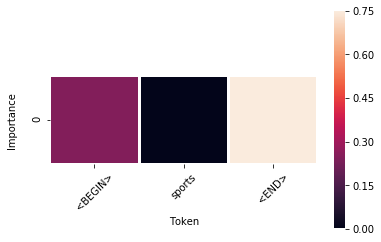

In [57]:
attn_matrix = attn_scores.detach().numpy()
ax = sns.heatmap(attn_matrix, linewidths=2, square=True)
tokens = ["<BEGIN>"]+preprocess_text(title).split(" ")+["<END>"]
ax.set_xticklabels(tokens, rotation=45)
ax.set_xlabel("Token")
ax.set_ylabel("Importance\n")
plt.show()

# Layer normalization

Recall from our CNN notebook that we used batch normalization to deal with internal covariant shift. Our activations will experience the same issues with RNNs but we will use a technique known as [layer normalization](https://arxiv.org/abs/1607.06450) (layernorm) to maintain zero mean unit variance on the activations. 

With layernorm it's a bit different from batchnorm. We compute the mean and var for every single sample (instead of each hidden dim) for each layer independently and then do the operations on the activations before they go through the nonlinearities. PyTorch's [LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) class abstracts all of this for us when we feed in inputs to the layer.

$ LN = \frac{a - \mu_{L}}{\sqrt{\sigma^2_{L} + \epsilon}}  * \gamma + \beta $

where:
* $a$ = activation | $\in \mathbb{R}^{NXH}$ ($N$ is the number of samples, $H$ is the hidden dim)
* $ \mu_{L}$ = mean of input| $\in \mathbb{R}^{NX1}$
* $\sigma^2_{L}$ = variance of input | $\in \mathbb{R}^{NX1}$
* $epsilon$ = noise
* $\gamma$ = scale parameter (learned parameter)
* $\beta$ = shift parameter (learned parameter)

<img src="figures/layernorm.png" width=400>

The most useful location to apply layernorm will be inside the RNN on the activations before the non-linearities. However, this is a bit involved and though PyTorch has a [LayerNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.LayerNorm) class, they do not have an RNN that has built in layernorm yet. You could implement the RNN yourself and manually add layernorm by following a similar setup like below.

```python
# Layernorm
for t in range(seq_size):
    # Normalize over hidden dim
    layernorm = nn.LayerNorm(args.hidden_dim)
    # Activating the module
    a = layernorm(x)
```